## Import packages we need

In [27]:
from pynwb import NWBHDF5IO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm
from pyrfume import from_cids
from tabulate import tabulate
from sklearn.metrics import roc_auc_score

from pyrfume.odorants import from_cids
from rdkit import Chem
from sklearn.metrics.pairwise import cosine_distances
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform

plt.rcParams['figure.dpi'] = 100

## Load and organize the trial info, unit info, and respiration data

In [ ]:
filepath = r"/Volumes/Shared/IFC/PostHoc_Python/Ephys_postHoc/24_12_06_NYUintensity2/040136/24_11_11/analysis_v1/040136__24_11_11.nwb"

# Open the file in read mode "r",
io = NWBHDF5IO(filepath, mode="r")
nwbfile = io.read()

# information about odor trials; includes timestamps + identifying info
trialsDF = nwbfile.get_time_intervals('odor_trials')
trialsDF = trialsDF.to_dataframe()

# Extract the first value from the odor_CID arrays
trialsDF['odor_CID_single'] = trialsDF['odor_CID'].apply(lambda x: x[0] if isinstance(x, (list, np.ndarray)) else x)

# Add a trial counter for each `odor_CID` within each session
trialsDF['trial_within_odor'] = trialsDF.groupby(['odor_CID_single']).cumcount() + 1

respObj = nwbfile.analysis["filtered_respiration_data"]
respf = np.asarray(respObj.data)  # Respiration data as an array
t_resp = np.asarray(respObj.timestamps)  # Respiration timestamps as an array

respObj = nwbfile.acquisition["respiration_data"]
respr = np.asarray(respObj.data)  # Respiration data as an array

# features extracted from respiration; inh is downward peaks, with pre/postx being the start/end of each peak
sniff_features = nwbfile.analysis['respiratory_features'].to_dataframe()

# spiking data; each row is a unit
rawunitsDF = nwbfile.units.to_dataframe()

io.close()

## Quality control for OB and PCX units

In [52]:
# Create a copy of rawunitsDF to avoid modifying the original DataFrame
unitsDF = rawunitsDF.copy()

# Define each QC criterion separately
location_drop = 'not in'  # Example: location filter for specific areas
ks_label = 'good'  # Example: Kilosort quality
SI_label = 'good'  # Example: SI quality
cutoff_hz = 0.2  # Example: firing rate cutoff
cutoff_amp = 10  # Example: amplitude cutoff
max_above = 400  # Example: max depth for 'PC:' locations

# Apply QC filtering directly on the dataframe
unitsDF = unitsDF[
    (~unitsDF['location'].str.contains(location_drop, na=False)) &  # Location drop filter
    (unitsDF['quality'] == ks_label) &  # Kilosort label filter
    (unitsDF['SI_quality'] == SI_label) &  # SI label filter
    (unitsDF['firing_rate'] > cutoff_hz) &  # Firing rate cutoff
    (unitsDF['amplitude'] > cutoff_amp) &  # Amplitude cutoff
    (unitsDF['location'].apply(
        lambda x: ('PC:' not in x) or (('PC:' in x) and (float(x.split(': ')[-1]) <= max_above))  # Depth filtering for PC only
    ))
]

# Safely split 'location' into 'region' and 'depth'
unitsDF[['region', 'depth']] = unitsDF['location'].str.split(':', expand=True)

# # Convert 'depth' to numeric type for analysis if needed
unitsDF['depth'] = unitsDF['depth'].astype(float)

In [53]:
trialsDF

,start_time,stop_time,iti,pins,odor_CID,concentration,fvo,fvc,fvB,laser,odor_CID_single,trial_within_odor
id,,,,,,,,,,,,
0,16.800667,18.817335,18,7,7410,0.10000,16.800667,18.817335,True,0,7410,1
1,40.117333,42.117333,18,7,7410,0.00000,40.117333,42.117333,True,0,7410,2
2,63.484000,65.517333,18,5,5281163,0.04300,63.484000,65.517333,True,0,5281163,1
3,86.650667,88.650667,18,8,8051,0.00005,86.650667,88.650667,True,0,8051,1
4,109.834000,111.850667,18,8,8051,0.00048,109.834000,111.850667,True,0,8051,2
...,...,...,...,...,...,...,...,...,...,...,...,...
285,6659.905567,6661.917333,18,8,8051,0.00048,6659.905567,6661.917333,True,0,8051,71
286,6683.167333,6685.184436,18,8,8051,0.10000,6683.167333,6685.184436,True,0,8051,72
287,6706.400667,6708.417333,18,7,7410,0.04300,6706.400667,6708.417333,True,0,7410,71


## Describe the stimuli and visualize the design used in this recording

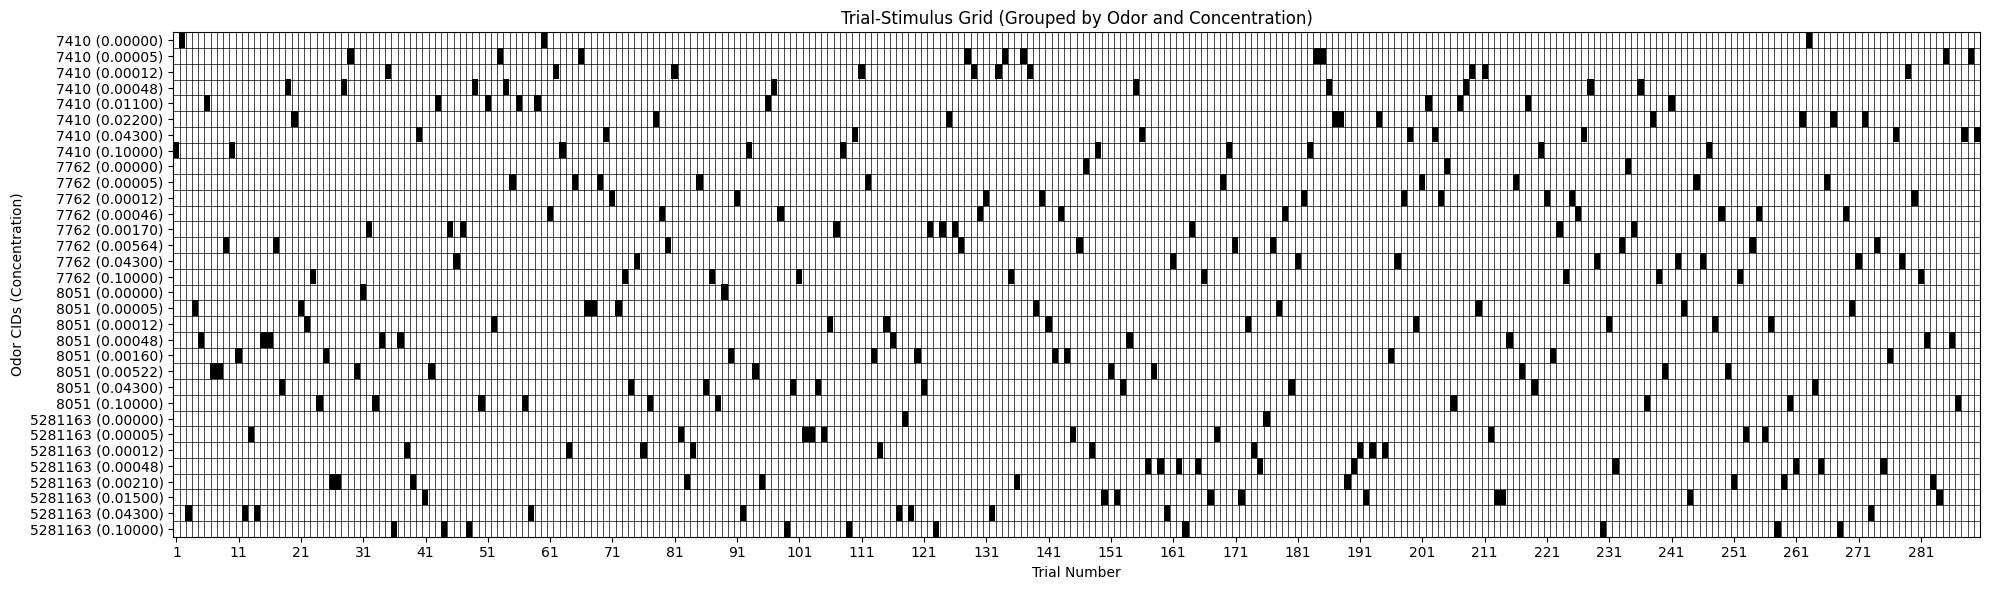

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

# Extract unique (odor_CID, concentration) pairs
unique_stimuli = sorted(
    trialsDF[['odor_CID_single', 'concentration']].drop_duplicates().itertuples(index=False),
    key=lambda x: (x.odor_CID_single, x.concentration)  # Sort by odor_CID first, then concentration
)

# Create a mapping from (odor_CID, concentration) to row index
stimulus_to_index = {stim: idx for idx, stim in enumerate(unique_stimuli)}

# Initialize the grid matrix
num_trials = len(trialsDF)
num_stimuli = len(unique_stimuli)
grid_matrix = np.full((num_stimuli, num_trials), np.nan)  # Start with NaNs

# Populate the grid matrix
for trial_id, row in trialsDF.iterrows():
    stim = (row['odor_CID_single'], row['concentration'])
    if stim in stimulus_to_index:
        stim_idx = stimulus_to_index[stim]
        grid_matrix[stim_idx, trial_id] = 1  # Mark trial as presented

# Define a colormap (NaN -> white, 1 -> black)
custom_colors = ["white", "black"]
custom_cmap = ListedColormap(custom_colors)
bounds = [-1, 0, 2]
norm = BoundaryNorm(bounds, custom_cmap.N, clip=False)

# Plot the grid
fig, ax = plt.subplots(figsize=(20, 6))
im = ax.imshow(grid_matrix, cmap=custom_cmap, norm=norm, aspect='auto', interpolation='none', rasterized=True)

# Add grid lines
for x in range(1, num_trials):
    ax.axvline(x - 0.5, color='black', linestyle='-', linewidth=0.5)
for y in range(1, num_stimuli):
    ax.axhline(y - 0.5, color='black', linestyle='-', linewidth=0.5)

# Set tick labels
ax.set_xticks(range(0, num_trials, 10))
ax.set_xticklabels(range(1, num_trials + 1, 10))
ax.set_yticks(range(num_stimuli))
ax.set_yticklabels([f"{stim[0]} ({stim[1]:.5f})" for stim in unique_stimuli])  # Show odor_CID and concentration

# Set labels and title
ax.set_xlabel("Trial Number")
ax.set_ylabel("Odor CIDs (Concentration)")
ax.set_title("Trial-Stimulus Grid (Grouped by Odor and Concentration)")

plt.tight_layout()
plt.show()

## Inspect respiration traces and alignment processing

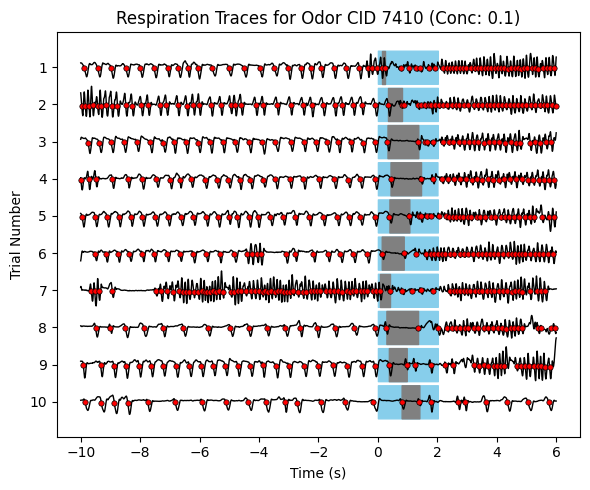

In [55]:
import numpy as np
import matplotlib.pyplot as plt

# Example: Filter trials based on a specific (odor_CID, concentration) pair
target_odor_CID, target_concentration = unique_CIDs[0], 0.1  # Replace with your target CID and concentration

# Filter trials based on the (odor_CID, concentration)
filtered_trials = trialsDF[
    (trialsDF['odor_CID_single'] == target_odor_CID) & 
    (trialsDF['concentration'] == target_concentration)
].reset_index()

# Initialize a list to store the respiration traces
respiration_traces_around_fvo = []

# Loop through filtered trials and extract respiration traces
for i, trial in filtered_trials.iterrows():
    # Get trial-specific info
    fvo_time = trial['fvo']
    fvc_time = trial['fvc']

    # Define the 16-second window (10s before, 6s after FVO)
    start_time = fvo_time - 10
    end_time = fvo_time + 6

    # Find the indices in `t_resp` that correspond to start_time and end_time
    start_idx = np.searchsorted(t_resp, start_time)
    end_idx = np.searchsorted(t_resp, end_time)

    # Extract respiration traces
    respiration_trace_window = respf[start_idx:end_idx]
    respiration_trace_window_r = respr[start_idx:end_idx] - np.mean(respr[start_idx:end_idx])

    # Normalize time axis relative to FVO
    trace_times = t_resp[start_idx:end_idx] - fvo_time

    # Store respiration trace data
    respiration_traces_around_fvo.append((respiration_trace_window, respiration_trace_window_r, trace_times, fvo_time, fvc_time))

# Create a plot with vertically offset line plots
plt.figure(figsize=(6, len(filtered_trials) / 2))

# Define the vertical offset for each trace
vertical_offset = 0.5  

# Iterate over all traces and plot each with an offset
for idx, (filtered_trace, raw_trace, trace_times, fvo_time, fvc_time) in enumerate(respiration_traces_around_fvo):

    # Normalize FVO times to match trace time window
    trial_fvc_time_normalized = fvc_time - fvo_time

    # Plot the blue shaded region for FVO to FVC
    plt.fill_between(
        trace_times,
        -idx * vertical_offset + vertical_offset / 2.25,
        -idx * vertical_offset - vertical_offset / 2.25,
        where=(trace_times >= 0) & (trace_times <= trial_fvc_time_normalized),
        color='skyblue',
        alpha=1,
        label="FVO to FVC" if idx == 0 else ""
    )

    # Plot the filtered respiration trace
    plt.plot(trace_times, filtered_trace - idx * vertical_offset, color='black', lw=1, label='Filtered Trace' if idx == 0 else "")

    # Get prex times for the current trial
    trial_prex_times = sniff_features[
        (sniff_features['prex'] >= trace_times[0] + fvo_time) & 
        (sniff_features['prex'] <= trace_times[-1] + fvo_time)
    ]

    # Normalize prex times relative to FVO
    trial_prex_times_normalized = trial_prex_times['prex'] - fvo_time

    # Find the first two prex times after FVO
    positive_prex_times = trial_prex_times_normalized[trial_prex_times_normalized > 0]
    if len(positive_prex_times) >= 2:
        first_prex = positive_prex_times.iloc[0]
        second_prex = positive_prex_times.iloc[1]

        # Shade the region between first and second prex times
        plt.fill_between(
            trace_times,
            -idx * vertical_offset + vertical_offset / 2.25,
            -idx * vertical_offset - vertical_offset / 2.25,
            where=(trace_times >= first_prex) & (trace_times <= second_prex),
            color='grey',
            alpha=1,
            zorder=1,
            label="First 2 PREX after FVO" if idx == 0 else ""
        )

    # Find corresponding amplitudes on the respiration trace
    prex_indices = np.searchsorted(trace_times, trial_prex_times_normalized)
    prex_amplitudes = filtered_trace[prex_indices] if len(prex_indices) > 0 else []

    # Plot prex points as red dots
    plt.scatter(
        trial_prex_times_normalized,
        prex_amplitudes - idx * vertical_offset,
        s=15, color='red', edgecolor='black', linewidth=0.5, alpha=1, zorder=3
    )

# Add labels and formatting
plt.title(f'Respiration Traces for Odor CID {target_odor_CID} (Conc: {target_concentration})')
plt.xlabel('Time (s)')
plt.ylabel('Trial Number')

# Set y-ticks at vertical spacing values, labeling them as trial numbers (1-indexed)
plt.yticks(np.arange(len(filtered_trials)) * -vertical_offset, labels=np.arange(1, len(filtered_trials) + 1))

plt.tight_layout()
plt.show()

## Define heatmap colormaps

In [56]:
from matplotlib import colormaps
cmap = colormaps['RdBu'].reversed()

# Truncate the upper half of the colormap (sequential colormap)
n_colors = 256  # Number of colors in the colormap
colors = cmap(np.linspace(0, 1, n_colors))  # Extract all colors
upper_colors = colors[n_colors // 2 :]  # Take the upper half
upper_cmap = LinearSegmentedColormap.from_list("Upper", upper_colors)

## Filter the good units located in the OB region

In [57]:
good_units = unitsDF[unitsDF['region'] == 'OB']#.head(150)

## Compute average raw rate, z scored rate, and auROC-based response index for each cell-odor pair
#### Choose between true first sniff or an x millisecond window for spike counts in the get_first_sniff_window function definition

### Using pre-odor baseline

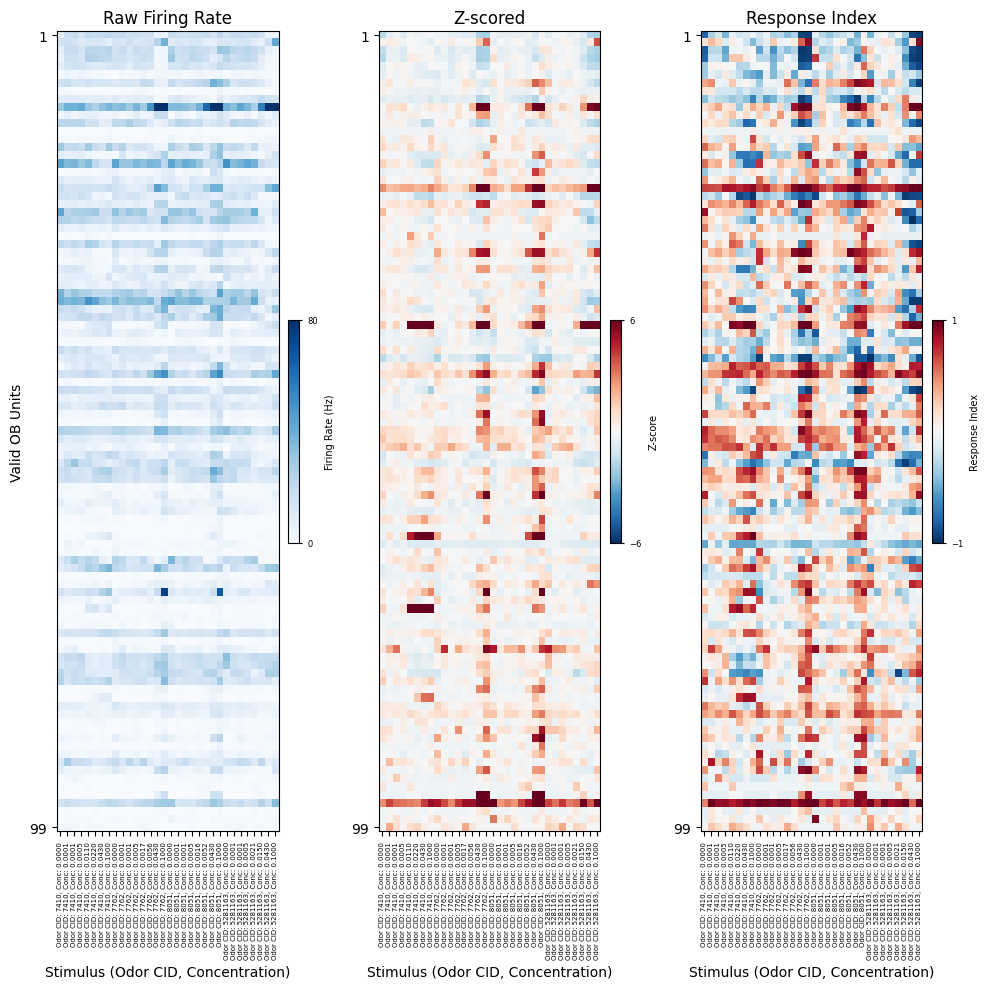

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# Define the first sniff window for each trial
def get_first_sniff_window(fvo, prex_times):
    # Find the first `prex` after fvo
    prex_after_fvo = prex_times[prex_times > fvo]
    if len(prex_after_fvo) < 2:
        return None, None
    start = prex_after_fvo.iloc[0]
    end = start + 0.3  # 300 ms window
    return start, end

# Define the last complete sniff window before fvo
def get_baseline_sniff_window(fvo, prex_times):
    # Find the `prex` timestamps that are before fvo
    prex_before_fvo = prex_times[prex_times < fvo]
    if len(prex_before_fvo) < 2:
        return None, None
    start = prex_before_fvo.iloc[-2]
    end = start + 0.3  # 300 ms window
    return start, end

# Initialize dictionaries for storing raw spike rates and baseline spike rates
raw_spike_rates = {}
baseline_spike_rates_by_unit = {unit_id: [] for unit_id in good_units.index}  # Baseline rates for each unit

# Iterate through trials (skip the first trial)
for _, trial in trialsDF[1:].iterrows():
    odor_cid_single, concentration, fvo = trial['odor_CID_single'], trial['concentration'], trial['fvo']
    prex_times = sniff_features['prex']
    
    # Identify the baseline sniff window
    baseline_start, baseline_end = get_baseline_sniff_window(fvo, prex_times)
    if baseline_start is None or baseline_end is None:
        continue  # Skip if baseline window can't be determined
    
    # Identify the first sniff window after fvo
    start, end = get_first_sniff_window(fvo, prex_times)
    if start is None or end is None:
        continue  # Skip if sniff window can't be determined
    
    # Group by odor CID and concentration (combined unique stimulus)
    unique_stimulus = (concentration, odor_cid_single)
    
    # Collect baseline spike rates
    for unit_id, unit in good_units.iterrows():
        spike_times = np.array(unit['spike_times'])
        spikes_in_baseline = spike_times[(spike_times >= baseline_start) & (spike_times < baseline_end)]
        sniff_duration = baseline_end - baseline_start
        spike_rate = len(spikes_in_baseline) / sniff_duration
        baseline_spike_rates_by_unit[unit_id].append(spike_rate)
    
    # Collect spike rates for all stimuli (grouped by both odor CID and concentration)
    if unique_stimulus not in raw_spike_rates:
        raw_spike_rates[unique_stimulus] = {unit_id: [] for unit_id in good_units.index}

    for unit_id, unit in good_units.iterrows():
        spike_times = np.array(unit['spike_times'])
        spikes_in_window = spike_times[(spike_times >= start) & (spike_times < end)]
        sniff_duration = end - start
        spike_rate = len(spikes_in_window) / sniff_duration
        raw_spike_rates[unique_stimulus][unit_id].append(spike_rate)

# Compute the baseline mean and std for each unit
baseline_mean_by_unit = {unit_id: np.mean(baseline_spike_rates) for unit_id, baseline_spike_rates in baseline_spike_rates_by_unit.items()}
baseline_std_by_unit = {unit_id: np.std(baseline_spike_rates) for unit_id, baseline_spike_rates in baseline_spike_rates_by_unit.items()}

# Filter out units with zero baseline standard deviation
valid_units = [unit_id for unit_id in good_units.index if baseline_std_by_unit[unit_id] > 0]

# Z-score the spike rates for each stimulus and unit (only for valid units)
z_scored_spike_rates = {}

for stimulus, unit_rates in raw_spike_rates.items():
    z_scored_spike_rates[stimulus] = {}
    for unit_id, rates in unit_rates.items():
        if unit_id not in valid_units:
            continue  # Skip units with zero baseline std (invalid units)
        
        baseline_mean = baseline_mean_by_unit[unit_id]
        baseline_std = baseline_std_by_unit[unit_id]
        
        # Z-score the rates for this unit
        z_scored_spike_rates[stimulus][unit_id] = [(rate - baseline_mean) / baseline_std for rate in rates]

# Average the raw and z-scored spike rates across trials for each stimulus and unit
averaged_raw_spike_rates = {}
for stimulus, unit_rates in raw_spike_rates.items():
    averaged_raw_spike_rates[stimulus] = {unit_id: np.mean(rates) for unit_id, rates in unit_rates.items()}

averaged_z_scored_spike_rates = {}
for stimulus, unit_rates in z_scored_spike_rates.items():
    averaged_z_scored_spike_rates[stimulus] = {unit_id: np.mean(rates) for unit_id, rates in unit_rates.items()}

# Compute the response index (auROC rescaled to [-1, 1])
response_index_by_stimulus = {}

for stimulus, unit_rates in raw_spike_rates.items():
    response_index_by_stimulus[stimulus] = {}
    for unit_id, rates in unit_rates.items():
        if unit_id not in valid_units:
            continue  # Skip invalid units

        # Baseline and stimulus-specific spike rates
        baseline_rates = baseline_spike_rates_by_unit[unit_id]
        stimulus_rates = rates

        # Compute auROC
        labels = [0] * len(baseline_rates) + [1] * len(stimulus_rates)
        scores = baseline_rates + stimulus_rates
        try:
            auroc = roc_auc_score(labels, scores)
            # Rescale auROC from [0, 1] to [-1, 1]
            response_index = 2 * (auroc - 0.5)
        except ValueError:
            response_index = 0  # Handle edge cases with no variability

        response_index_by_stimulus[stimulus][unit_id] = response_index

# # Create the sorted data matrix for raw spike rates
# raw_data_matrix = np.zeros((len(valid_units), len(averaged_raw_spike_rates)))
# for col_idx, stimulus in enumerate(averaged_raw_spike_rates.keys()):
#     unit_rates = averaged_raw_spike_rates[stimulus]
#     for row_idx, unit_id in enumerate(valid_units):
#         raw_data_matrix[row_idx, col_idx] = unit_rates[unit_id]

# # Create the sorted data matrix for z-scored spike rates
# data_matrix = np.zeros((len(valid_units), len(averaged_z_scored_spike_rates)))
# for col_idx, stimulus in enumerate(averaged_z_scored_spike_rates.keys()):
#     unit_rates = averaged_z_scored_spike_rates[stimulus]
#     for row_idx, unit_id in enumerate(valid_units):
#         data_matrix[row_idx, col_idx] = unit_rates[unit_id]

# # Create the response index matrix
# response_index_matrix = np.zeros((len(valid_units), len(response_index_by_stimulus)))
# for col_idx, stimulus in enumerate(response_index_by_stimulus.keys()):
#     unit_indices = response_index_by_stimulus[stimulus]
#     for row_idx, unit_id in enumerate(valid_units):
#         response_index_matrix[row_idx, col_idx] = unit_indices.get(unit_id, 0)

# Sort stimuli by both odor CID and concentration
sorted_stimuli = sorted(raw_spike_rates.keys(), key=lambda x: (x[1], x[0]))  # Sort first by CID, then by concentration

# Create the sorted data matrix for raw spike rates
raw_data_matrix = np.zeros((len(valid_units), len(sorted_stimuli)))
for col_idx, stimulus in enumerate(sorted_stimuli):
    unit_rates = averaged_raw_spike_rates[stimulus]
    for row_idx, unit_id in enumerate(valid_units):
        raw_data_matrix[row_idx, col_idx] = unit_rates[unit_id]

# Create the sorted data matrix for z-scored spike rates
data_matrix = np.zeros((len(valid_units), len(sorted_stimuli)))
for col_idx, stimulus in enumerate(sorted_stimuli):
    unit_rates = averaged_z_scored_spike_rates[stimulus]
    for row_idx, unit_id in enumerate(valid_units):
        data_matrix[row_idx, col_idx] = unit_rates[unit_id]

# Create the response index matrix
response_index_matrix = np.zeros((len(valid_units), len(sorted_stimuli)))
for col_idx, stimulus in enumerate(sorted_stimuli):
    unit_indices = response_index_by_stimulus[stimulus]
    for row_idx, unit_id in enumerate(valid_units):
        response_index_matrix[row_idx, col_idx] = unit_indices.get(unit_id, 0)

# Plot the heatmaps side by side
fig, axes = plt.subplots(1, 3, figsize=(10, 10))  # Adjust width to fit 3 heatmaps

# Raw firing rate heatmap
ax = axes[0]
im_raw = ax.imshow(raw_data_matrix, aspect='auto', cmap="Blues", origin='upper')
ax.set_xticks(np.arange(len(averaged_raw_spike_rates)))
# ax.set_xticklabels([f"{stimulus[1]} (Conc: {stimulus[0]})" for stimulus in averaged_raw_spike_rates.keys()], rotation=90, fontsize=5)
ax.set_xticklabels([f"Odor CID: {stimulus[1]}, Conc: {stimulus[0]:.4f}" for stimulus in sorted_stimuli], rotation=90, fontsize=5)
ax.set_yticks([0, len(valid_units)-1])
ax.set_yticklabels([1, len(valid_units)])
ax.set_xlabel('Stimulus (Odor CID, Concentration)')
ax.set_ylabel('Valid OB Units')
ax.set_title('Raw Firing Rate')
im_raw.set_clim(0, 80)
cbar_raw = plt.colorbar(im_raw, ax=ax, fraction=0.046, pad=0.04)
cbar_raw.ax.tick_params(labelsize=6, length=2)
cbar_raw.set_ticks([0, 80])
cbar_raw.set_label('Firing Rate (Hz)', fontsize=7, labelpad=5)

# Z-scored heatmap
ax = axes[1]
im_zscore = ax.imshow(data_matrix, aspect='auto', cmap=cmap, origin='upper')
ax.set_xticks(np.arange(len(averaged_z_scored_spike_rates)))
ax.set_xticklabels([f"Odor CID: {stimulus[1]}, Conc: {stimulus[0]:.4f}" for stimulus in sorted_stimuli], rotation=90, fontsize=5)
ax.set_yticks([0, len(valid_units)-1])
ax.set_yticklabels([1, len(valid_units)])
ax.set_xlabel('Stimulus (Odor CID, Concentration)')
ax.set_title('Z-scored')
im_zscore.set_clim(-6, 6)
cbar_zscore = plt.colorbar(im_zscore, ax=ax, fraction=0.046, pad=0.04)
cbar_zscore.ax.tick_params(labelsize=6, length=2)
cbar_zscore.set_ticks([-6, 6])
cbar_zscore.set_label('Z-score', fontsize=7, labelpad=5)

# Response index heatmap
ax = axes[2]
im_response = ax.imshow(response_index_matrix, aspect='auto', cmap=cmap, origin='upper')
ax.set_xticks(np.arange(len(response_index_by_stimulus)))
ax.set_xticklabels([f"Odor CID: {stimulus[1]}, Conc: {stimulus[0]:.4f}" for stimulus in sorted_stimuli], rotation=90, fontsize=5)
ax.set_yticks([0, len(valid_units)-1])
ax.set_yticklabels([1, len(valid_units)])
ax.set_xlabel('Stimulus (Odor CID, Concentration)')
ax.set_title('Response Index')
im_response.set_clim(-1, 1)
cbar_response = plt.colorbar(im_response, ax=ax, fraction=0.046, pad=0.04)
cbar_response.ax.tick_params(labelsize=6, length=2)
cbar_response.set_ticks([-1, 1])
cbar_response.set_label('Response Index', fontsize=7, labelpad=5)

plt.tight_layout()
plt.show()